# CA3 - Experiment Design and Hypothesis Testing

In [1]:
# Initial Setup from the BSE introduction practical:

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

I use the AA implementation from the BSE github and the GDX implmentation from Snashall's code, inserted into the original BSE.

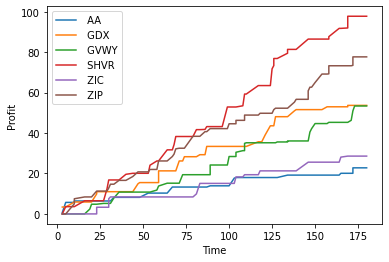

In [2]:
import pandas as pd

trades_df = pd.read_csv('test_1_avg_balance.csv')

fig = plt.figure()
x = trades_df.iloc[:,1]
ax = plt.subplot(111)

for i in range(0,6):
    y = trades_df.iloc[:,4*i+7]

    ax.plot(x,y,label = trades_df.iloc[:,4*i+4][0])

#plt.xlim(0,300)
plt.xlabel('Time')
plt.ylabel('Profit')
ax.legend()
plt.show()

In [20]:
# Experiment code 
# M1
trials_per_market = 200

sellers_spec = [("ZIP", 5),("ZIC", 5),("SHVR", 5),("GVWY", 5),("AA",5),("GDX",5)]
buyers_spec = sellers_spec
traders_spec = {"sellers":sellers_spec, "buyers":buyers_spec}

sup_range = (10, 50)
dem_range = sup_range

start_time = 0
end_time = 180

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

fname = 'balanced_static.csv'

tdump = open(fname, 'w')

tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer'))
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');

trial = 0
while trial < trials_per_market:
        # trial_id = 'trial%04d' % trial
        trial_id = trial
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, False, True)
        tdump.flush()
        trial = trial + 1



0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

In [21]:
# M4

sup_range = (20, 60)
dem_range = sup_range

while trial < 2*trials_per_market:
        # trial_id = 'trial%04d' % trial
        trial_id = trial
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, False, True)
        tdump.flush()
        trial = trial + 1


200;  

201;  

202;  

203;  

204;  

205;  

206;  

207;  

208;  

209;  

210;  

211;  

212;  

213;  

214;  

215;  

216;  

217;  

218;  

219;  

220;  

221;  

222;  

223;  

224;  

225;  

226;  

227;  

228;  

229;  

230;  

231;  

232;  

233;  

234;  

235;  

236;  

237;  

238;  

239;  

240;  

241;  

242;  

243;  

244;  

245;  

246;  

247;  

248;  

249;  

250;  

251;  

252;  

253;  

254;  

255;  

256;  

257;  

258;  

259;  

260;  

261;  

262;  

263;  

264;  

265;  

266;  

267;  

268;  

269;  

270;  

271;  

272;  

273;  

274;  

275;  

276;  

277;  

278;  

279;  

280;  

281;  

282;  

283;  

284;  

285;  

286;  

287;  

288;  

289;  

290;  

291;  

292;  

293;  

294;  

295;  

296;  

297;  

298;  

299;  

300;  

301;  

302;  

303;  

304;  

305;  

306;  

307;  

308;  

309;  

310;  

311;  

312;  

313;  

314;  

315;  

316;  

317;  

318;  

319;  

320;  

321;  

322;  

323;  

324;  


In [22]:
# M2

sup_range = (10, 50)
dem_range = (25, 35)

while trial < 3*trials_per_market:
        # trial_id = 'trial%04d' % trial
        trial_id = trial
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, False, True)
        tdump.flush()
        trial = trial + 1


400;  

401;  

402;  

403;  

404;  

405;  

406;  

407;  

408;  

409;  

410;  

411;  

412;  

413;  

414;  

415;  

416;  

417;  

418;  

419;  

420;  

421;  

422;  

423;  

424;  

425;  

426;  

427;  

428;  

429;  

430;  

431;  

432;  

433;  

434;  

435;  

436;  

437;  

438;  

439;  

440;  

441;  

442;  

443;  

444;  

445;  

446;  

447;  

448;  

449;  

450;  

451;  

452;  

453;  

454;  

455;  

456;  

457;  

458;  

459;  

460;  

461;  

462;  

463;  

464;  

465;  

466;  

467;  

468;  

469;  

470;  

471;  

472;  

473;  

474;  

475;  

476;  

477;  

478;  

479;  

480;  

481;  

482;  

483;  

484;  

485;  

486;  

487;  

488;  

489;  

490;  

491;  

492;  

493;  

494;  

495;  

496;  

497;  

498;  

499;  

500;  

501;  

502;  

503;  

504;  

505;  

506;  

507;  

508;  

509;  

510;  

511;  

512;  

513;  

514;  

515;  

516;  

517;  

518;  

519;  

520;  

521;  

522;  

523;  

524;  


In [23]:
# M3

dem_range = (10, 50)
sup_range = (25, 35)

while trial < 4*trials_per_market:
        # trial_id = 'trial%04d' % trial
        trial_id = trial
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, False, True)
        tdump.flush()
        trial = trial + 1


600;  

601;  

602;  

603;  

604;  

605;  

606;  

607;  

608;  

609;  

610;  

611;  

612;  

613;  

614;  

615;  

616;  

617;  

618;  

619;  

620;  

621;  

622;  

623;  

624;  

625;  

626;  

627;  

628;  

629;  

630;  

631;  

632;  

633;  

634;  

635;  

636;  

637;  

638;  

639;  

640;  

641;  

642;  

643;  

644;  

645;  

646;  

647;  

648;  

649;  

650;  

651;  

652;  

653;  

654;  

655;  

656;  

657;  

658;  

659;  

660;  

661;  

662;  

663;  

664;  

665;  

666;  

667;  

668;  

669;  

670;  

671;  

672;  

673;  

674;  

675;  

676;  

677;  

678;  

679;  

680;  

681;  

682;  

683;  

684;  

685;  

686;  

687;  

688;  

689;  

690;  

691;  

692;  

693;  

694;  

695;  

696;  

697;  

698;  

699;  

700;  

701;  

702;  

703;  

704;  

705;  

706;  

707;  

708;  

709;  

710;  

711;  

712;  

713;  

714;  

715;  

716;  

717;  

718;  

719;  

720;  

721;  

722;  

723;  

724;  


## Statistical testing

Perform a WMW U Test to assess whether GDX or AA performs significantly better than the other 

In [24]:
trials_df = pd.read_csv('balanced_static.csv')
trials_df.head()

,expid,time,best bid,best offer,type,balance,number of traders,profit per trader,type.1,balance.1,...,balance.4,number of traders.4,profit per trader.4,type.5,balance.5,number of traders.5,profit per trader.5,best bid,best offer,
0,0,180,36,41,AA,0,10,0.0,GDX,633,...,306,10,30.6,ZIP,631,10,63.1,36,41,
1,1,180,31,33,AA,64,10,6.4,GDX,509,...,309,10,30.9,ZIP,825,10,82.5,31,33,
2,2,180,32,37,AA,432,10,43.2,GDX,23,...,338,10,33.8,ZIP,1303,10,130.3,32,37,
3,3,180,30,44,AA,227,10,22.7,GDX,279,...,227,10,22.7,ZIP,494,10,49.4,30,44,
4,4,180,32,35,AA,41,10,4.1,GDX,186,...,523,10,52.3,ZIP,484,10,48.4,32,35,


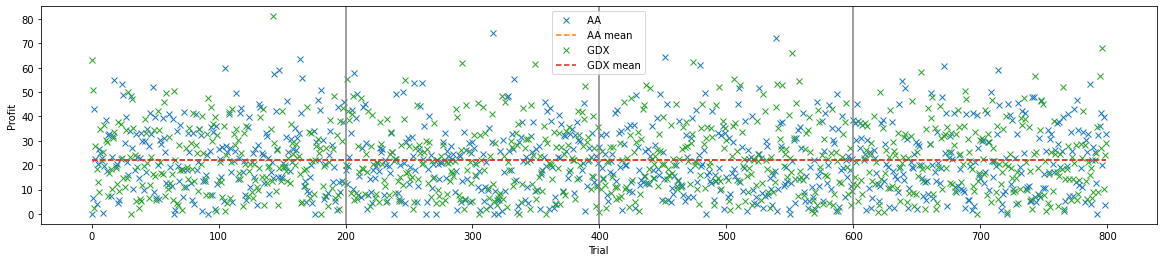

In [38]:
fig = plt.figure()
x = trials_df.iloc[:,0]
ax = plt.subplot(111)


for i in range(0,6):
    y = trials_df.iloc[:,4*i+7]
    y_mean = [np.mean(y)]*len(x)
    
    if((trades_df.iloc[:,4*i+4][0] == ' AA') | (trades_df.iloc[:,4*i+4][0] == " GDX")):
        ax.plot(x,y,'x', markersize = 6,label = trades_df.iloc[:,4*i+4][0])
        mean_line = ax.plot(x,y_mean, linestyle='--', label = trades_df.iloc[:,4*i+4][0] + " mean")

ax.axvline(x=trials_per_market, color='grey')
ax.axvline(x=2*trials_per_market, color='grey')
ax.axvline(x=3*trials_per_market, color='grey')

plt.rcParams['figure.figsize'] = [20, 4]
plt.xlabel('Trial')
plt.ylabel('Profit')
ax.legend()
plt.show()

In [26]:
AA_balances = trials_df.iloc[:,7]
GDX_balances = trials_df.iloc[:,11]


In [27]:
import scipy.stats as sp

# H0 GDX outperforms AA in symmetric supply/demand market populated with SHVR, GVWY
# One sided test as only interested in greater than case
# Significance level 0.05

sp.wilcoxon(GDX_balances, AA_balances)#, alternative='greater')

WilcoxonResult(statistic=157794.5, pvalue=0.8052480805263875)

Not significant - pvalue > 0.05

BUT can't use WMW U  as not independent - performance score of AA in each case likely dependent on GDX

In [28]:
sp.ttest_rel(GDX_balances,AA_balances)#, alternative='greater')

Ttest_relResult(statistic=-0.1269445003691226, pvalue=0.8990162643665189)

In [36]:
### Individual Tests

AA_balances_M1 = trials_df.iloc[:trials_per_market-1,7]
GDX_balances_M1 = trials_df.iloc[:trials_per_market-1,11]

AA_balances_M2 = trials_df.iloc[trials_per_market:2*trials_per_market-1,7]
GDX_balances_M2 = trials_df.iloc[trials_per_market:2*trials_per_market-1,11]

AA_balances_M3 = trials_df.iloc[2*trials_per_market:3*trials_per_market-1,7]
GDX_balances_M3 = trials_df.iloc[2*trials_per_market:3*trials_per_market-1,11]

AA_balances_M4 = trials_df.iloc[3*trials_per_market:4*trials_per_market-1,7]
GDX_balances_M4 = trials_df.iloc[3*trials_per_market:4*trials_per_market-1,11]


In [34]:
print("Wilcoxon test results")
# greater for one sided tests
print("M1 p value: " + sp.wilcoxon(GDX_balances_M1,AA_balances_M1, alternative="greater")[1].astype('str'))
print("M2 p value: " + sp.wilcoxon(GDX_balances_M2,AA_balances_M2, alternative="greater")[1].astype('str'))
print("M3 p value: " + sp.wilcoxon(GDX_balances_M3,AA_balances_M3, alternative="greater")[1].astype('str'))
print("M4 p value: " + sp.wilcoxon(GDX_balances_M4,AA_balances_M4, alternative="greater")[1].astype('str'))
print("Overall p value: " + sp.wilcoxon(GDX_balances,AA_balances, alternative="greater")[1].astype('str'))

Wilcoxon test results
M1 p value: 0.9352147444592032
M2 p value: 0.5230380049644285
M3 p value: 0.09564275835769392
M4 p value: 0.5414341529488574
Overall p value: 0.5973759597368062


In [35]:
print("MW-U test results")
print("M1 p value: " + sp.mannwhitneyu(GDX_balances_M1,AA_balances_M1, alternative="greater")[1].astype('str'))
print("M2 p value: " + sp.mannwhitneyu(GDX_balances_M2,AA_balances_M2, alternative="greater")[1].astype('str'))
print("M3 p value: " + sp.mannwhitneyu(GDX_balances_M3,AA_balances_M3, alternative="greater")[1].astype('str'))
print("M4 p value: " + sp.mannwhitneyu(GDX_balances_M4,AA_balances_M4, alternative="greater")[1].astype('str'))
print("Overall p value: " + sp.mannwhitneyu(GDX_balances,AA_balances, alternative="greater")[1].astype('str'))

MW-U test results
M1 p value: 0.9161370169263383
M2 p value: 0.43133021760648566
M3 p value: 0.08671790082596742
M4 p value: 0.5760210841270835
Overall p value: 0.5323876377841334
